In [1]:
import torch

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
from pycocotools.coco import COCO

In [4]:
coco = COCO('/nmnt/x04-hdd/coco_dataset/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=300.74s)
creating index...
index created!


In [5]:
# cat_ids = coco.getCatIds(['bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck'])
# img_ids = set()
# for cat_id in cat_ids:
#     img_ids.update(coco.getImgIds(catIds=[cat_id]))
    
# img_ids = list(img_ids)

cat_ids = []
img_ids = coco.getImgIds(catIds=cat_ids)

In [6]:
len(img_ids)

82783

In [25]:
from imageio import imread
from functools import lru_cache
from skimage.transform import rescale

def load_single(img_id):
    image = coco.loadImgs([img_id])[0]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=image['id']))
    img = imread(f'/nmnt/x04-hdd/coco_dataset/train2014/{image["file_name"]}')    
    boxes = [x['bbox'] for x in anns if x['category_id'] in cat_ids or not cat_ids]
    
    scale = 400 / min(img.shape[:2])
    boxes = scale * np.array(boxes)
    img, boxes = rescale(img, scale, mode='constant'), boxes.tolist()
    
    return img, boxes

def load_img():
    return load_single(np.random.choice(img_ids))

def apply_mask(params, mask):
    return np.array([params[:, i][mask] for i in range(4)])

In [8]:
from matplotlib import patches

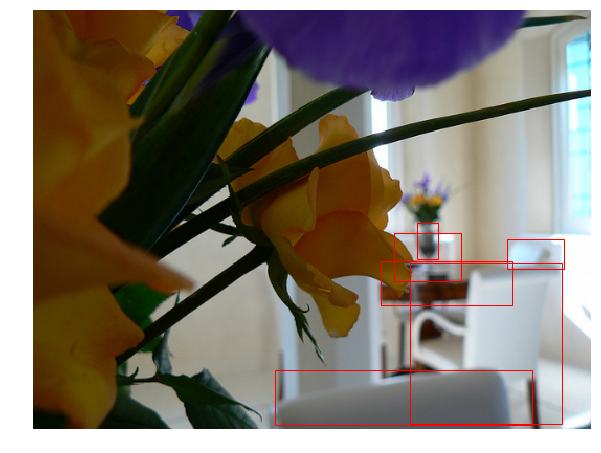

In [9]:
img, boxes = load_img()
_, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img)
ax.set_axis_off()
for x, y, w, h in boxes:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

In [15]:
from model_zoo.detection import *
from model_zoo.utils import to_np, to_var
from model_zoo.models.retina_net import RetinaNet

In [11]:
lambda_r, lambda_c = 1, 10

In [12]:
scales = [[8, 16, 32], [32, 64, 128], [64, 128, 256]]
ratios = [1, .5, 2]
level_anchors = [get_anchor_shapes(scales=s, ratios=ratios) for s in reversed(scales)]

In [14]:
net = RetinaNet(len(level_anchors[0]), 1).cuda()

In [17]:
from dpipe.torch.utils import focal_loss_with_logits
from torch import nn

cls_loss = focal_loss_with_logits
reg_loss = nn.SmoothL1Loss()

In [18]:
optimizer = torch.optim.Adam(net.parameters())

In [19]:
from tensorboard_easy import Logger

logger = Logger('/nmnt/media/home/memax/tb_garbage/retina/focal_loss')
log_c = logger.make_log_scalar('classification')
log_r = logger.make_log_scalar('regression')
log_s = logger.make_log_scalar('sum')

In [20]:
from tqdm import tqdm_notebook as tqdm

In [21]:
from dpipe.torch.model import set_lr
from dpipe.train.lr_policy import Exponential

In [22]:
lr = Exponential(
    initial=1e-4,
    multiplier=.5,
    step_length=80_000,
)

In [ ]:
for _ in tqdm(range(500_000)):
    set_lr(optimizer, lr.lr);
    
    img, boxes = load_img()
    if not boxes or img.ndim != 3:
        continue
    
    boxes = np.random.permutation(boxes)
    
    x = Variable(torch.from_numpy(img.transpose(2, 0, 1)[None])).float().cuda()
    loss_r = loss_c = 0
    prediction = [(z[0], z[1].view(z[1].shape[0], -1, 4, *z[1].shape[2:])) for z in net(x)]
    for anchors, (class_, box_params) in zip(level_anchors, prediction):
        masks, params = get_gt(x.shape[-2:], boxes, box_params.shape[-2:], anchors)
        masks, params = masks[None], params[None]
        
        if not masks.any():
            continue

        t_mask = torch.from_numpy(masks.astype('uint8')).cuda()

        loss_c += cls_loss(class_, to_var(masks))
        for i in range(4):
            loss_r += reg_loss(box_params[:, :, i][t_mask], to_var(params[:, :, i][masks]))
    
    loss = loss_c * lambda_c + lambda_r * loss_r
    
    if type(loss) is int:
        continue

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    lr.epoch_finished()
    log_c(loss_c.data.cpu()[0])
    log_r(loss_r.data.cpu()[0])
    log_s(loss.data.cpu()[0])

HBox(children=(IntProgress(value=0, max=500000), HTML(value='')))

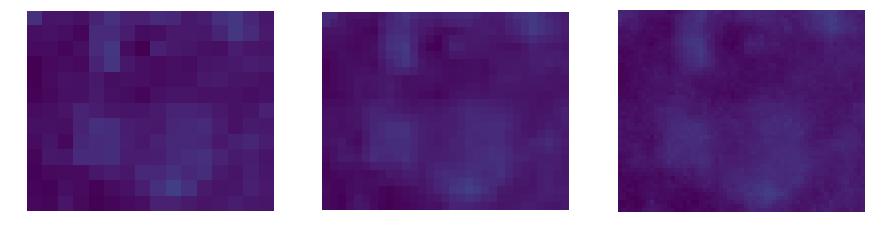

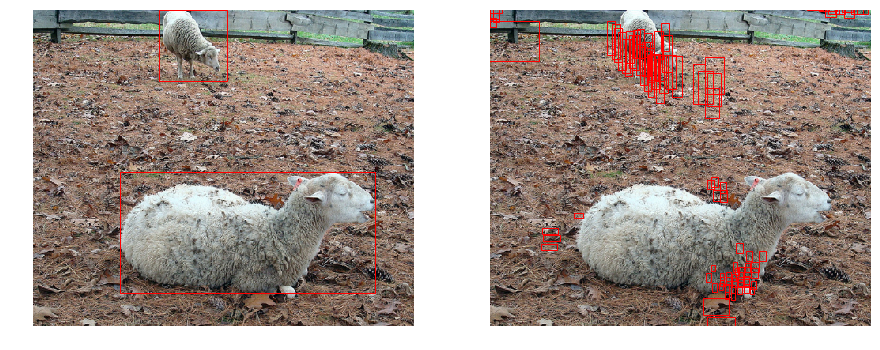

In [26]:
axes = plt.subplots(1, len(prediction), figsize=(15,15))[1]

x_coords, x_probs = [], []
for ax, (class_, box_params) in zip(axes, prediction):
    pred = box_params[0].data.cpu().numpy()
    probs = torch.sigmoid(class_).data.cpu().numpy()[0]
    
    ax.imshow(probs.mean(0), vmax=1)
    ax.set_axis_off()
    
    a_s = anchors[..., None, None]
    space, shape = pred[:, :2], pred[:, 2:]
    scale = np.array(img.shape[:2]) / box_params.shape[-2:]
    coordinates = get_grid(box_params.shape[-2:]) * scale[:, None, None]
    space = space * a_s + coordinates[None]
    shape = a_s * np.exp(shape)

    pred_params = np.concatenate([space, shape], 1)

    mask = probs > .5
#     tt = 
#     print(space[:, 0][mask].max(), space[:, 0][mask].min())
    x_coords.append(apply_mask(pred_params, mask))
    x_probs.extend(probs[mask])

ax, ax2 = plt.subplots(1, 2, figsize=(15,15))[1]
ax.imshow(img)
ax.set_axis_off()
for x, y, w, h in boxes:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

ax2.imshow(img)
ax2.set_axis_off()
x_coords, x_probs = np.concatenate(x_coords, -1), np.array(x_probs)

if x_coords.size:
    max_obj = 100
    xs, ys, ws, hs = non_max_suppression(x_coords, x_probs).T

    for x, y, w, h in zip(xs[:max_obj], ys, ws, hs):
        ax2.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

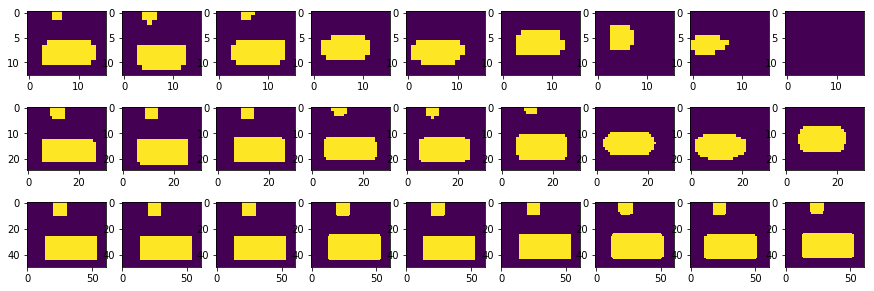

In [27]:
axes = plt.subplots(len(prediction), len(level_anchors[0]), figsize=(15,5))[1]

for ax_, anchors, (class_, box_params) in zip(axes, level_anchors, prediction):
    masks, params = get_gt(img.shape[:2], boxes, box_params.shape[-2:], anchors)
    for ax, mask in zip(ax_, masks):
        ax.imshow(mask)